<a href="https://colab.research.google.com/github/RickBerends/Domain-Specific-BERT-for-Depression-Detection/blob/main/Fine_tuneBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers==3

     |████████████████████████████████| 757kB 7.7MB/s 
     |████████████████████████████████| 3.0MB 35.0MB/s 
     |████████████████████████████████| 1.2MB 48.2MB/s 
     |████████████████████████████████| 901kB 52.7MB/s 


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
import pandas as pd
import re
import os
import glob
sys.path.insert(0, '/content/drive/Mijn Drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv",usecols=[0,5],encoding='latin-1', names=['label', 'text'])

In [ ]:
df = df.replace(4,1)

In [ ]:
df

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
def prepare_reduced_data(data):
    df = data
    df = df.set_index(pd.Series(list(range(len(data)))))
    return df

In [ ]:
import logging
logging.basicConfig(level=logging.ERROR)

In [ ]:
def defining_bert_tokenizer(PRE_TRAINED_MODEL_NAME):
    tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, truncation=True)
    return tokenizer

class GPReviewDataset(Dataset):
    
    def __init__(self, doc, targets, tokenizer, max_len):
        self.doc = doc
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.doc)
  
    def __getitem__(self, item):
        doc = str(self.doc[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
                    doc,
                    add_special_tokens=True,
                    max_length=self.max_len,
                    return_token_type_ids=False,
                    pad_to_max_length=True,
                    return_attention_mask=True,
                    return_tensors='pt',
                    )

        return {
            'doc_text': doc,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
            }


def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        doc=df.text.to_numpy(),
        targets=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2
        )

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.5)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
    ):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["doc_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values


In [ ]:
if __name__=="__main__":
    
    """full_data=final_df
    df=prepare_reduced_data(full_data)"""

    PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
    tokenizer=defining_bert_tokenizer(PRE_TRAINED_MODEL_NAME)

    sample_txt='Personal Health Record (Extract)\nCreated on October 24, 2019\nPatient\nSteven Fuerst\nBirthdate\nDecember 10, 1979\nRace\nInformation not\navailable'

    tokens = tokenizer.tokenize(sample_txt)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    encoding = tokenizer.encode_plus(
                      sample_txt,
                      max_length=26,
                      #64
                      add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                      return_token_type_ids=False,
                      pad_to_max_length=True,
                      trunctation=True,
                      return_attention_mask=True,
                      return_tensors='pt',  # Return PyTorch tensors
                    )

    
    
    MAX_LEN = 26
    #256
    BATCH_SIZE = 16

    train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])

    # we will use temp_text and temp_labels to create validation and test set
    val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                    random_state=2018, 
                                                                    test_size=0.5, 
                                                                    stratify=temp_labels)
    
    df_train = pd.DataFrame()
    df_train['label'] = train_labels
    df_train['text'] = train_text
    df_val = pd.DataFrame()
    df_val['label'] = val_labels
    df_val['text'] = val_text
    df_test = pd.DataFrame()
    df_test['label'] = test_labels
    df_test['text'] = test_text

    train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
    val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
    test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

    data = next(iter(train_data_loader))

    bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

    last_hidden_state, pooled_output = bert_model(
                    input_ids=encoding['input_ids'], 
                    attention_mask=encoding['attention_mask'])

    model = SentimentClassifier(2)

    os.chdir('/content/drive/My Drive')
    path = 'saved_weights2.pt'
    model.load_state_dict(torch.load(path))

    model = model.to(device)

    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)


    EPOCHS = 4

    optimizer = AdamW(model.parameters(), lr=0.00001, correct_bias=False)
    total_steps = len(train_data_loader) * EPOCHS

    scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
    )

    loss_fn = nn.CrossEntropyLoss().to(device)


    history = defaultdict(list)
    best_valid_loss = 3

    for epoch in range(EPOCHS):

        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
        )

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
        )

        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_loss < best_valid_loss:
          best_valid_loss = val_loss
          torch.save(model.state_dict(), 'saved_weights3.pt')
        
    test_acc, _ = eval_model(
          model,
          test_data_loader,
          loss_fn,
          device,
          len(df_test)
        )
    print('\nTest Accuracy:\n')
    print(test_acc.item())

    y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
    )

    print(classification_report(y_test, y_pred, target_names=['Not depressed', 'Depressed']))

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Keyword arguments {'trunctation': True} not recognized.


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was n


Epoch 1/4
----------


Streaming output truncated to the last 5000 lines.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

RuntimeError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Old code

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

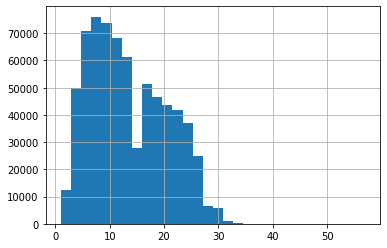

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 26

In [ ]:
# tokenize and encode sequences in the training set
def get_tokenize(df): 
  tokens = tokenizer.batch_encode_plus(
    df.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
  )
  return tokens

tokens_train = get_tokenize(train_text)
tokens_val = get_tokenize(val_text)
tokens_test = get_tokenize(test_text)

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[1. 1.]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]

  os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    print(step)
    print(batch, len(batch))
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    sent_id, mask, labels = batch

    sent_id = sent_id.to(device)
    mask = mask.to(device)
    labels = labels.to(device)

    # push the batch to gpu
    #batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    print(step) 
    print(batch)
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss += loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, train_acc = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights1.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
0
[tensor([[  101,  1030, 13675, 23555,  2102,  9692,  2851,  4013, 26775, 14083,
         19185,  2012,  2147,  1012,  1012,  1012,  2054,  2055,  2017,  1029,
         23156,  2006,  3998,   999,   999,   102],
        [  101,  1030,  3312, 23451,  2075, 18168,  2546,  2290,  2064,  1005,
          1056,  2903,  2023,  2003,  4507,  2823,  1012,  1012,  1012,  2027,
          2453,  2663, 13299,   999, 14398,   102],
        [  101,  2183,  2000,  2147,  2101,  7910, 23644, 23644, 23644,  2232,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [  101,  1030,  5557,  4160, 21405,  1998,  2017,  2145,  2024, 17012,
          2213,  1045,  2071,  2074,  4521,  2070,  2621, 29593,  2074, 19779,
           102,     0,     0,     0,     0,     0],
        [  101,  1996,  5055,  2024,  2041,  1010,  1010,  2821,  2158,  1012,
          1012,  1012,  2008,  1005,  1055,  2025,  4658,  1004

RuntimeError: ignored

In [ ]:
len(tokenizer)

30522

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

NameError: ignored